In [1]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-04-03, 10:00, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sta
import scipy.optimize
import statsmodels.stats.api as sms

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
#fn_confirmed='time_series_19-covid-Confirmed.csv' # deprecated 3/23/2020
fn_confirmed='time_series_covid19_confirmed_global.csv'
#fn_deaths='time_series_19-covid-Deaths.csv'
fn_deaths='time_series_covid19_deaths_global.csv'
#fn_recovered='time_series_19-covid-Recovered.csv'
fn_recovered='time_series_covid19_recovered_global.csv'

fn_confirmedUS='time_series_covid19_confirmed_US.csv'
fn_deathsUS='time_series_covid19_deaths_US.csv'
fn_population='https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
fn_rkiData='https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv'

In [2]:
df_rki=pd.read_csv(fn_rkiData,index_col=None)
df_rki.Meldedatum=pd.to_datetime(df_rki.Meldedatum)

df_rki.tail()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
32431,5,Nordrhein-Westfalen,SK Gelsenkirchen,A15-A34,W,1,0,677148,2020-03-15 00:00:00+00:00,5513,"03.04.2020, 00:00 Uhr",0,-9
32432,5,Nordrhein-Westfalen,SK Gelsenkirchen,A15-A34,W,1,0,677149,2020-03-17 00:00:00+00:00,5513,"03.04.2020, 00:00 Uhr",0,-9
32433,5,Nordrhein-Westfalen,SK Gelsenkirchen,A15-A34,W,2,0,677150,2020-03-18 00:00:00+00:00,5513,"03.04.2020, 00:00 Uhr",0,-9
32434,5,Nordrhein-Westfalen,SK Gelsenkirchen,A15-A34,W,1,0,677151,2020-03-24 00:00:00+00:00,5513,"03.04.2020, 00:00 Uhr",0,-9
32435,5,Nordrhein-Westfalen,SK Gelsenkirchen,A15-A34,W,2,0,677152,2020-03-26 00:00:00+00:00,5513,"03.04.2020, 00:00 Uhr",0,-9


In [3]:
# get John's Hopkins data and consolidate for countries.
def getJHUdata(fn,valName='cases',groupCol=1,colName='country'):
    dropCols=['Lat', 'Long','UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Long_', 'Combined_Key','Population']
    dropHere=[]
    df = pd.read_csv(fn,index_col=None)
    for d in dropCols:
        if d in df.columns:
            dropHere.append(d)
    df=df.drop(dropHere,axis=1)
    df=df.set_index([*df.columns[:2]])
    df=df.stack().reset_index()
    df.columns=[*df.columns[:2],'date',valName]
    df.date=pd.to_datetime(df.date)
    
    df=df.groupby([df.columns[groupCol],'date']).sum().reset_index()
    df.columns=[colName,*df.columns[1:]]
    return df

In [4]:
dfcUS = getJHUdata(url+fn_confirmedUS,groupCol=0)
dfcUS.tail()

,country,date,cases
4171,Wyoming,2020-03-29,86
4172,Wyoming,2020-03-30,94
4173,Wyoming,2020-03-31,109
4174,Wyoming,2020-04-01,130
4175,Wyoming,2020-04-02,150


In [5]:
dfc = getJHUdata(url+fn_confirmed)
dfc.tail()

,country,date,cases
13027,Zimbabwe,2020-03-29,7
13028,Zimbabwe,2020-03-30,7
13029,Zimbabwe,2020-03-31,8
13030,Zimbabwe,2020-04-01,8
13031,Zimbabwe,2020-04-02,9


In [6]:
dfd = getJHUdata(url+fn_deaths,valName='deaths')
dfd.tail()

,country,date,deaths
13027,Zimbabwe,2020-03-29,1
13028,Zimbabwe,2020-03-30,1
13029,Zimbabwe,2020-03-31,1
13030,Zimbabwe,2020-04-01,1
13031,Zimbabwe,2020-04-02,1


In [7]:
dfdUS = getJHUdata(url+fn_deathsUS,valName='deaths',groupCol=0)
dfdUS.tail()

,country,date,deaths
4171,Wyoming,2020-03-29,0
4172,Wyoming,2020-03-30,0
4173,Wyoming,2020-03-31,0
4174,Wyoming,2020-04-01,0
4175,Wyoming,2020-04-02,0


In [8]:
dfr = getJHUdata(url+fn_recovered,'recovered')
dfr.tail()

,country,date,recovered
13027,Zimbabwe,2020-03-29,0
13028,Zimbabwe,2020-03-30,0
13029,Zimbabwe,2020-03-31,0
13030,Zimbabwe,2020-04-01,0
13031,Zimbabwe,2020-04-02,0


In [9]:
dfrUS=dfdUS.copy()
dfrUS.columns=[*dfr.columns]
dfrUS.recovered=0


In [10]:
dfc=pd.concat([dfc,dfcUS])
dfd=pd.concat([dfd,dfdUS])
dfr=pd.concat([dfr,dfrUS])

In [11]:
# get population data.
# Note, many country names don't match between population and case data.
dfp = pd.read_csv(fn_population)
dfp=dfp[dfp.Year==dfp.Year.max()]
dfp.columns=[*dfp.columns[:-1],'population']
dfp.replace('United States','US',inplace=True)
dfp.head()

,Country Name,Country Code,Year,population
56,Arab World,ARB,2016,4.064527e+08
113,Caribbean small states,CSS,2016,7.245472e+06
170,Central Europe and the Baltics,CEB,2016,1.029741e+08
227,Early-demographic dividend,EAR,2016,3.170542e+09
284,East Asia & Pacific,EAS,2016,2.296786e+09


In [12]:
df=dfc.merge(dfd,on=[*dfc.columns[:2]])
df=df.merge(dfr,on=[*dfc.columns[:2]])
df=df.merge(dfp[[dfp.columns[0],'population']],how='left',left_on='country',right_on=dfp.columns[0])
df=df.drop('Country Name',axis=1)
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,country,date,cases,deaths,recovered,population
0,Afghanistan,2020-01-22,0,0,0,34656032.0
1,Afghanistan,2020-01-23,0,0,0,34656032.0
2,Afghanistan,2020-01-24,0,0,0,34656032.0
3,Afghanistan,2020-01-25,0,0,0,34656032.0
4,Afghanistan,2020-01-26,0,0,0,34656032.0


In [44]:
# Compute ratios
df['cdRatio']=df.deaths/df.cases
df['casePerPop']=df.cases/df.population
df['activeCases']=df.cases-df.deaths-df.recovered
df['crRatio']=1-df.recovered/df.cases

df['newCases']=df.groupby(['country']).diff().cases
df['newDeaths']=df.groupby(['country']).diff().deaths

In [14]:
# Show all country names in the case data
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Alabama                       Alaska
Albania                       Algeria                       American Samoa
Andorra                       Angola                        Antigua and Barbuda
Argentina                     Arizona                       Arkansas
Armenia                       Australia                     Austria
Azerbaijan                    Bahamas                       Bahrain
Bangladesh                    Barbados                      Belarus
Belgium                       Belize                        Benin
Bhutan                        Bolivia                       Bosnia and Herzegovina
Botswana                      Brazil                        Brunei
Bulgaria                      Burkina Faso                  Burma
Burundi                       Cabo Verde                    California
Cambodia                      Cameroon                      Canada
Central African Republic      Chad                          Chile
China              

In [15]:
# Select countries for plots.
plotCountries=['Germany','Italy','Spain','France','Portugal', 'Korea, South','US','China', 'New York']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


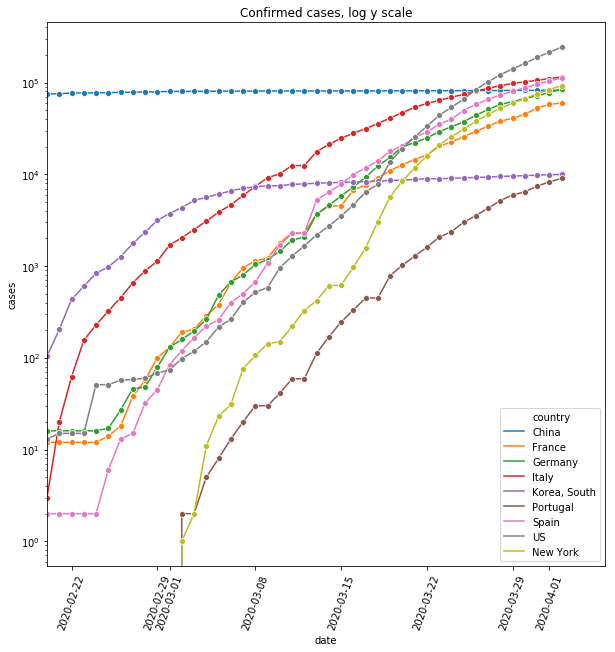

In [16]:
# Plot cases on log y scale
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

Note similar slopes of european countries. Italy took of earlier

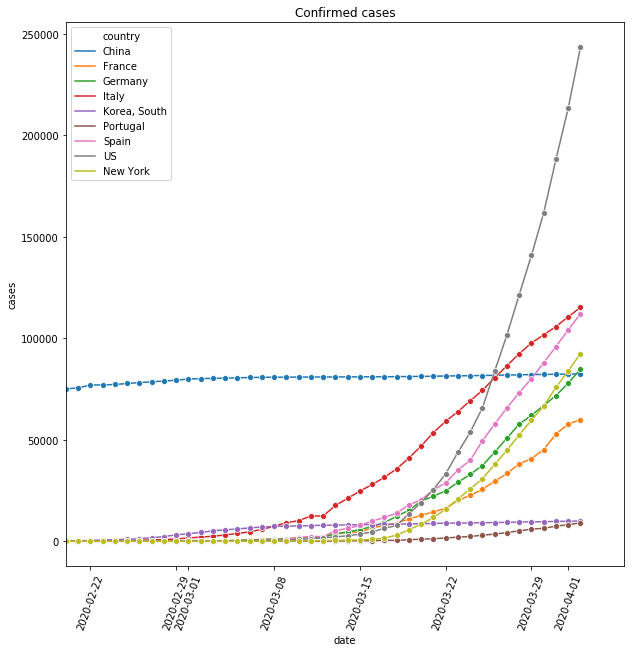

In [17]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.title('Confirmed cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

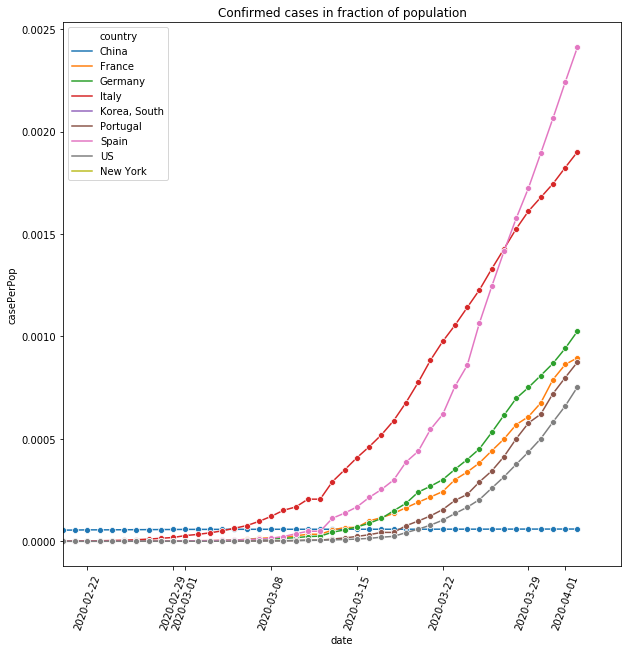

In [18]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='casePerPop',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.title('Confirmed cases in fraction of population');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

# New cases over time: Have any countries flattened the curve?
inspired by a NYT article -
https://www.nytimes.com/interactive/2020/03/19/world/coronavirus-flatten-the-curve-countries.html

Singapore, Taiwan, Japan, Thailand slowed the onset of exponential growth. South Korea and China managed to reduce new cases greatly.

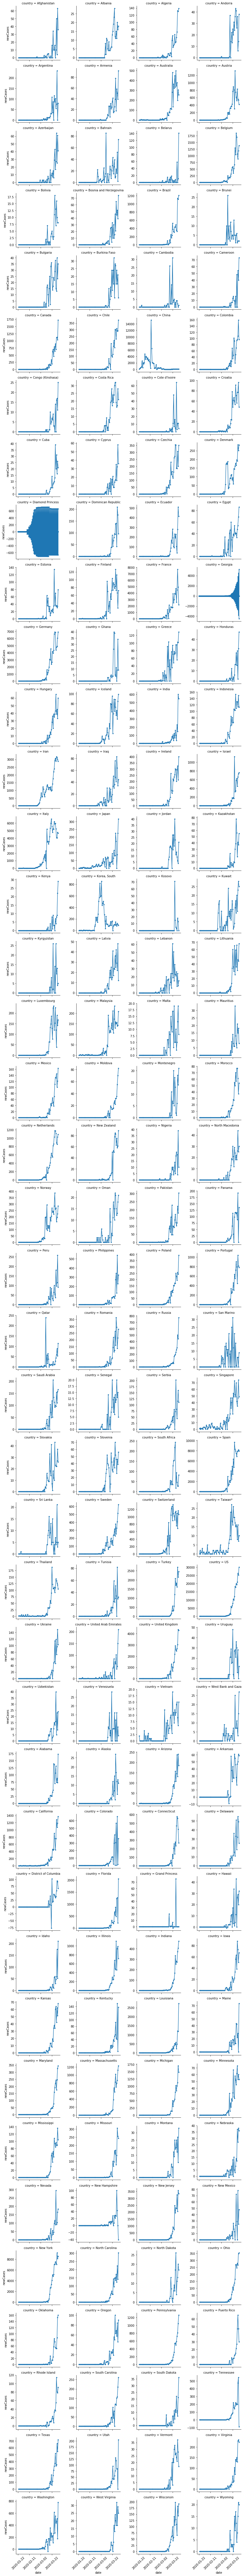

In [19]:
HighCountries=df[df.cases>100].country.unique()
ix=df.country.isin(HighCountries)

g = sns.FacetGrid(df[ix], col="country",  palette="tab20c",
                     col_wrap=4, height=3,sharey=False)

g.map(plt.plot, "date", "newCases",marker='.')

g.set(xticks=df.date.unique()[::20], xticklabels=df.date.unique()[::20])
g.set_xticklabels(rotation=45);



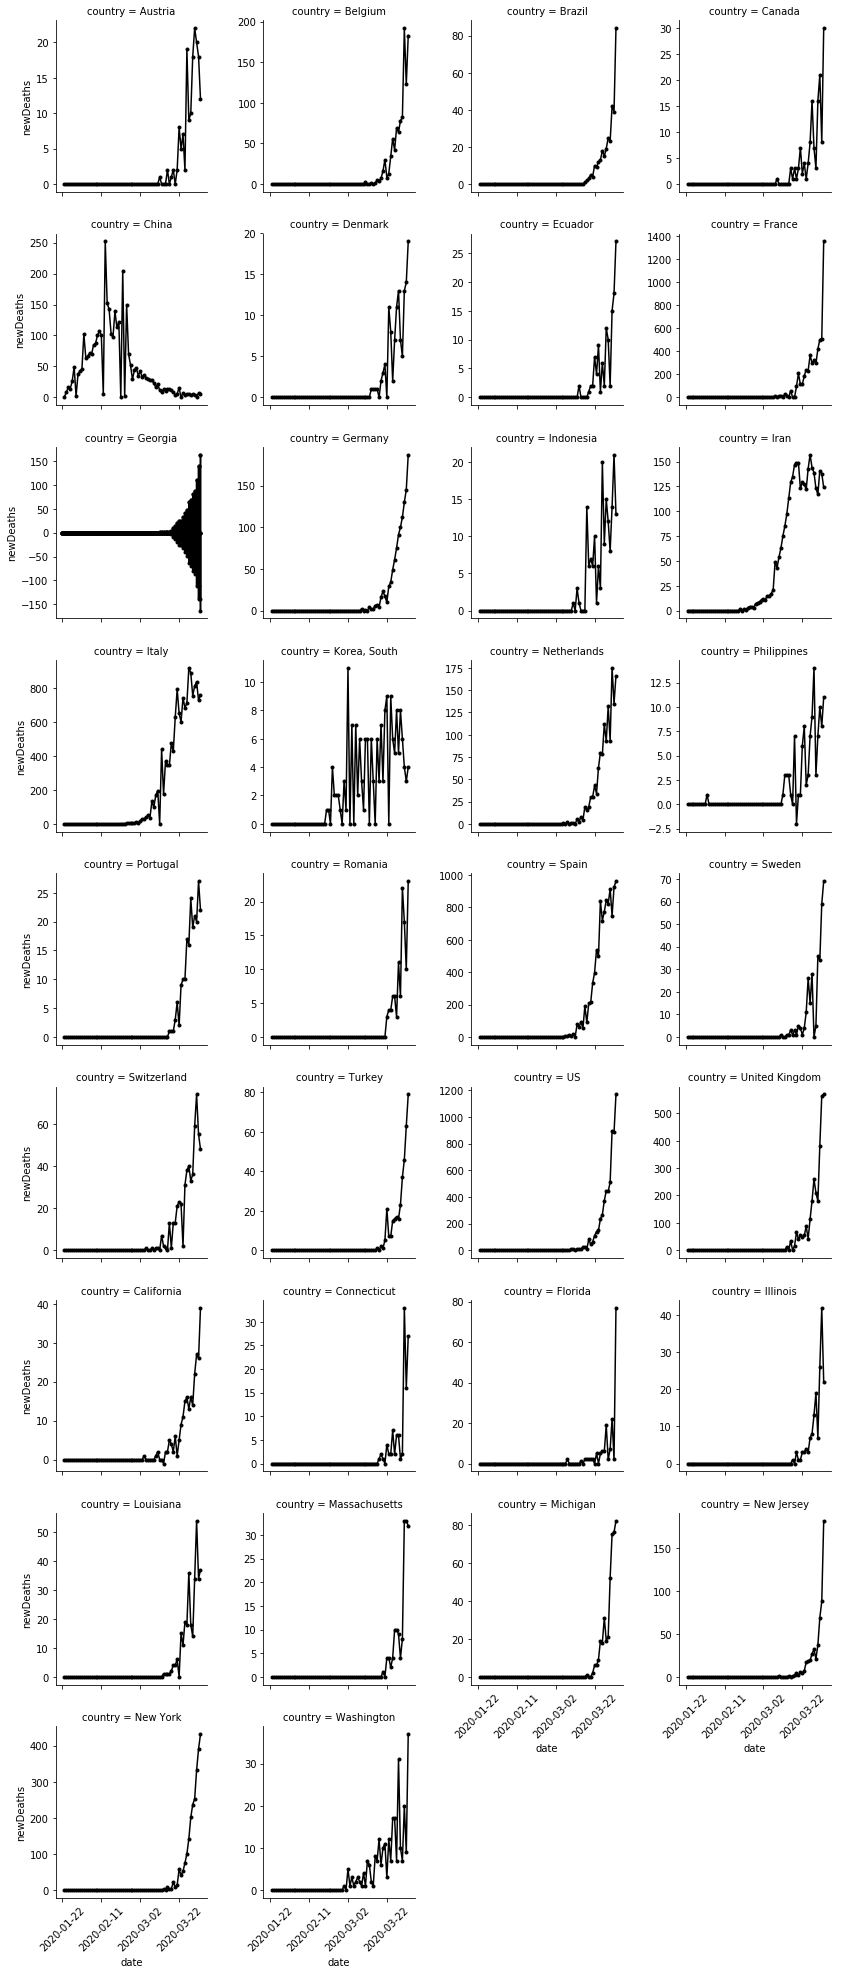

In [46]:
HighCountries=df[df.deaths>100].country.unique()
ix=df.country.isin(HighCountries)

g = sns.FacetGrid(df[ix], col="country",
                     col_wrap=4, height=3,sharey=False)

g.map(plt.plot, "date", "newDeaths",marker='.',color='k')

g.set(xticks=df.date.unique()[::20], xticklabels=df.date.unique()[::20])
g.set_xticklabels(rotation=45);



In [20]:
# Show latest data for Germany
ix=df.country.isin(['Germany'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
5757,Germany,2020-03-31,71808,775,16100,82667685.0,0.010793,0.000869,54933,0.775791,4923.0
5758,Germany,2020-04-01,77872,920,18700,82667685.0,0.011814,0.000942,58252,0.759862,6064.0
5759,Germany,2020-04-02,84794,1107,22440,82667685.0,0.013055,0.001026,61247,0.735359,6922.0


In [21]:
# Show latest data for US

ix=df.country.isin(['US'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
13245,US,2020-03-31,188172,3873,7024,323127513.0,0.020582,0.000582,177275,0.962672,26365.0
13246,US,2020-04-01,213372,4757,8474,323127513.0,0.022294,0.000660,200141,0.960285,25200.0
13247,US,2020-04-02,243453,5926,9001,323127513.0,0.024341,0.000753,228526,0.963028,30081.0


# Plot cases aligned to date of crossing 100 cases

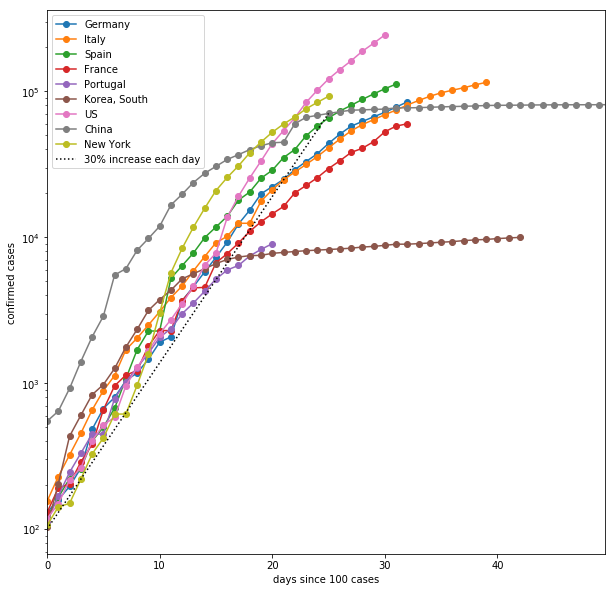

In [22]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
ul=ax.get_xlim()[1]
ax.set_xlim([0,ul-25])
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

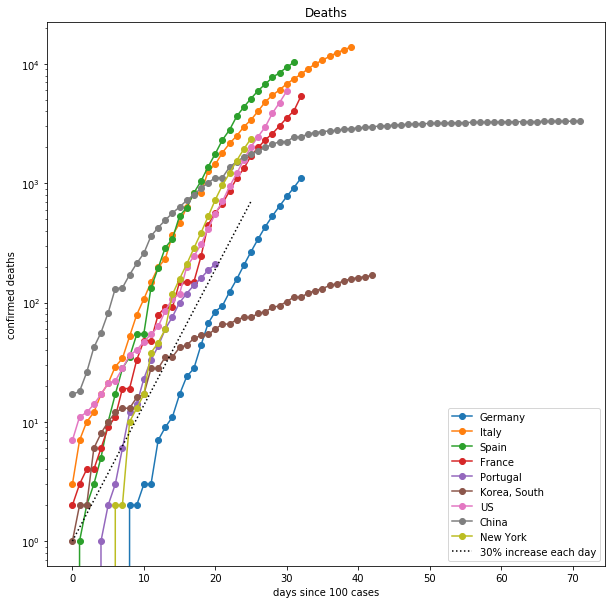

In [23]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        tsDeaths=df[ix].deaths.values
        ax.plot(tsDeaths[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=1*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed deaths')
plt.title('Deaths');

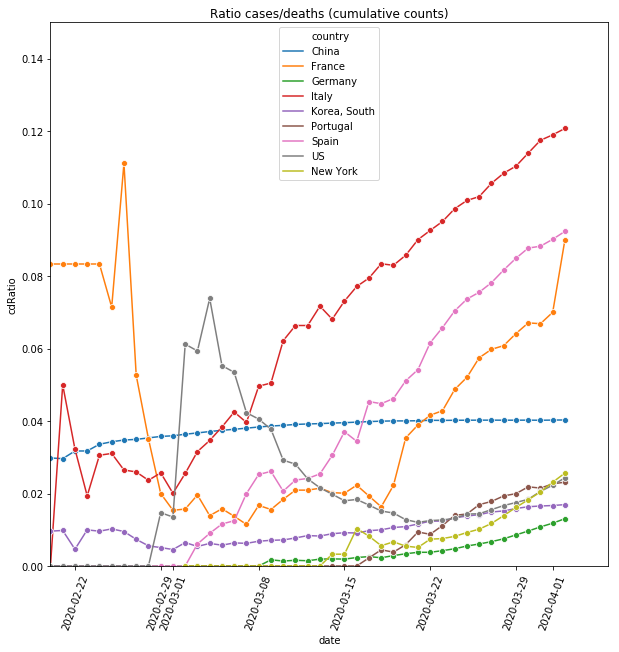

In [24]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cdRatio',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
plt.ylim([0,.15])
plt.title('Ratio cases/deaths (cumulative counts)')
plt.xlim(left=plotStartDate);

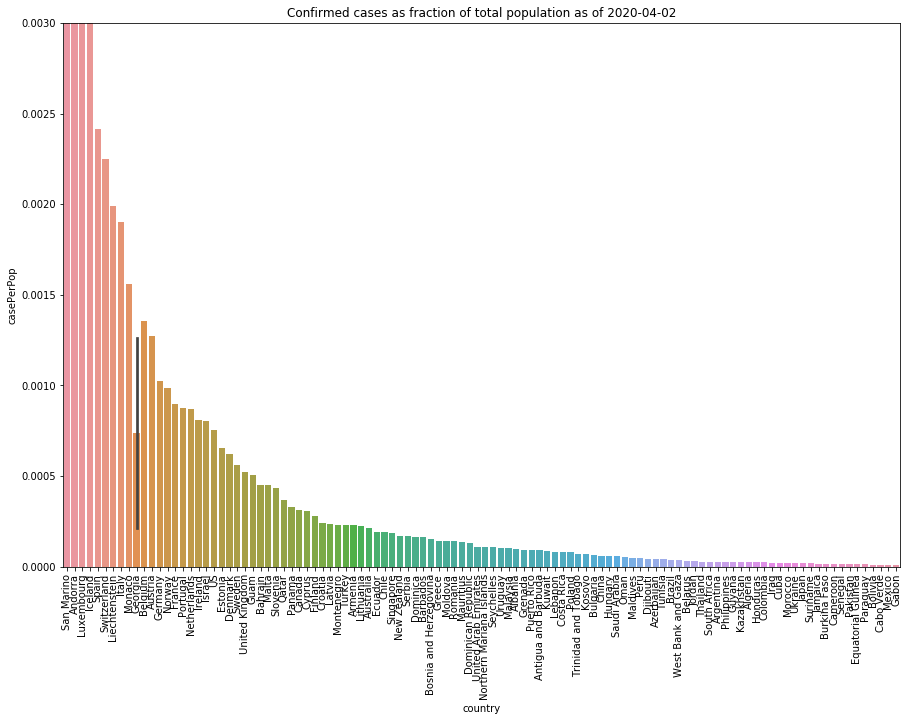

In [25]:
plt.subplots(figsize=(15,10))
ix=(df.date==df.date.max())&(df.casePerPop>0.00001)
sns.barplot(data=df[ix].sort_values(by=['casePerPop'],ascending=False),
            x='country',y='casePerPop')
plt.ylim([0,.003])
plt.title('Confirmed cases as fraction of total population as of '+str(df.date.max()))
plt.xticks(rotation=90);

#  % daily increase in reported cases per country for recent history
## testing only countries with > 250 cases

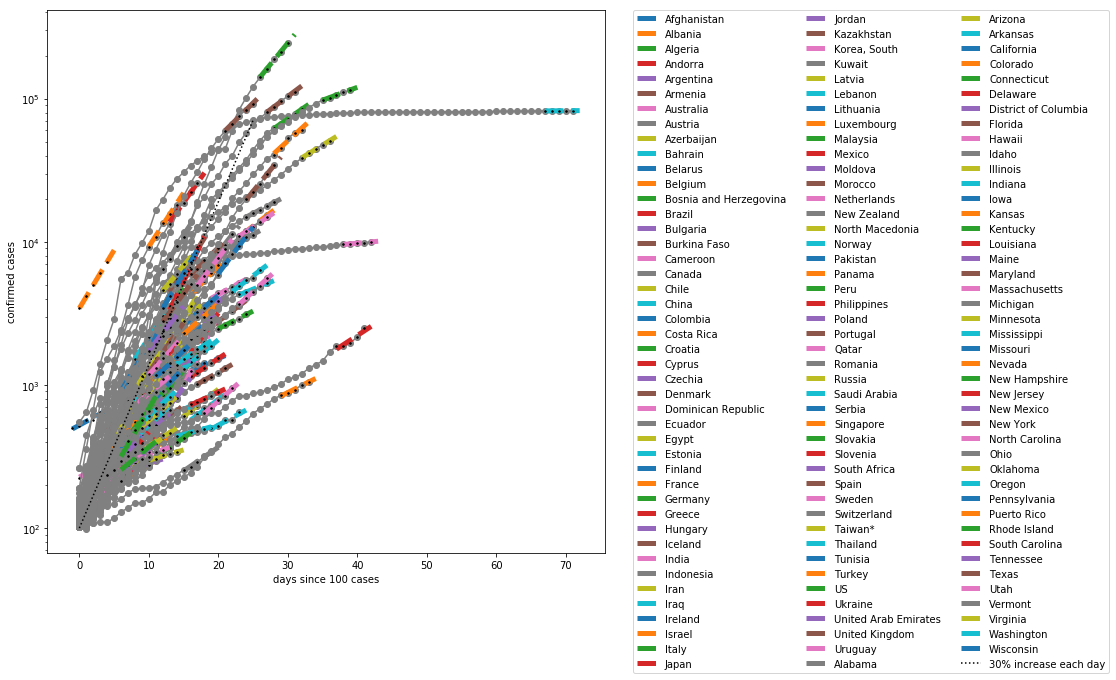

In [26]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

HighCountries=df[df.cases>250].country.unique()

allSlopes=np.zeros((len(HighCountries),100))*np.nan
allIntercept=np.zeros((len(HighCountries),100))*np.nan

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if (ts[-1]>100) and len(ts)<500:
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopes[i,j+inflect+1]=s
            allIntercept[i,j+inflect+1]=itc
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=3,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

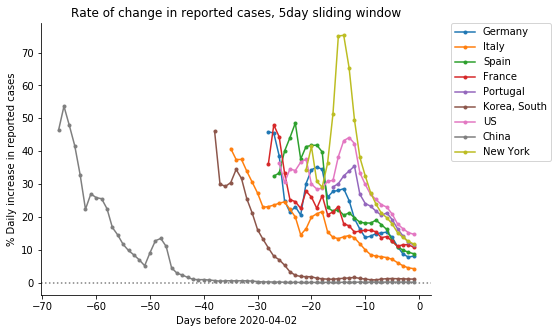

In [27]:
fix,ax=plt.subplots(figsize=(7,5))

today=np.where(np.nansum(allSlopes,axis=0)==0)[0][1]
xt=np.arange(allSlopes.shape[1])-today
for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ax.plot(xt,100*(10**allSlopes[ic,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.legend()
plt.axhline(0,ls=':',color='gray')
plt.ylabel('% Daily increase in reported cases')
plt.xlabel('Days before '+ str(df.date.max()));
plt.title('Rate of change in reported cases, 5day sliding window')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()

#  % daily increase in active cases per country for recent history
## testing only countries with > 250 cases

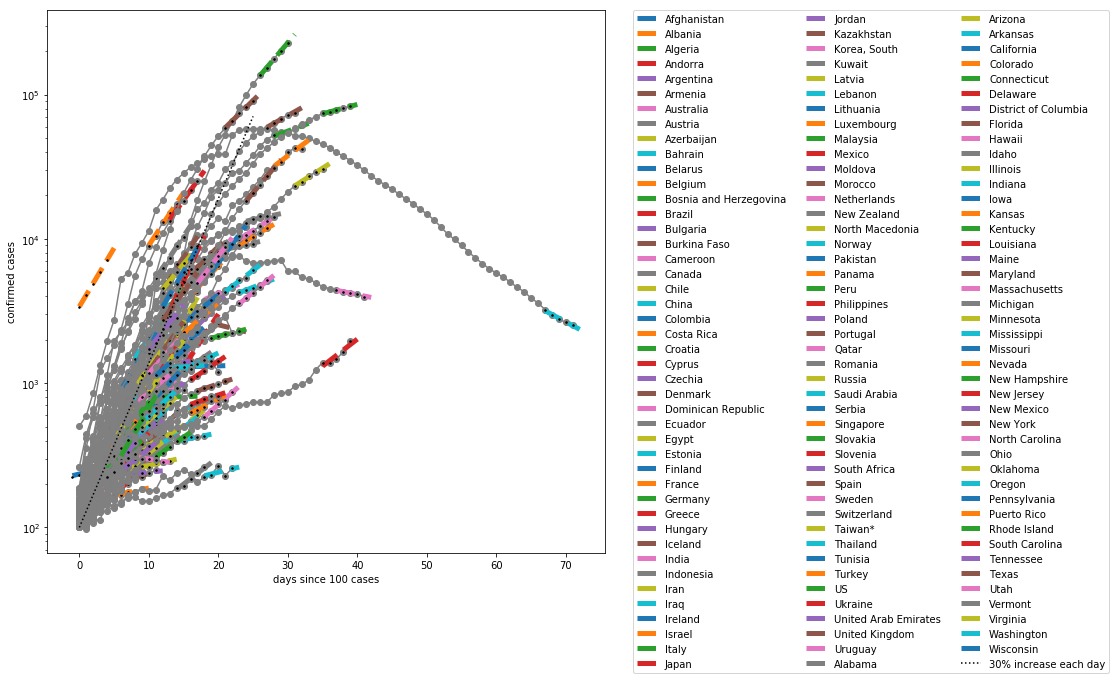

In [28]:
fix,ax=plt.subplots(figsize=(10,10))

allSlopesActive=np.zeros((len(HighCountries),100))*np.nan
allInterceptActive=np.zeros((len(HighCountries),100))*np.nan

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].activeCases.values
    if (ts[-1]>100) and len(ts)<500:        
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopesActive[i,j+inflect+1]=s
            allInterceptActive[i,j+inflect+1]=itc
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=3,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

# Summary plot for rates of change

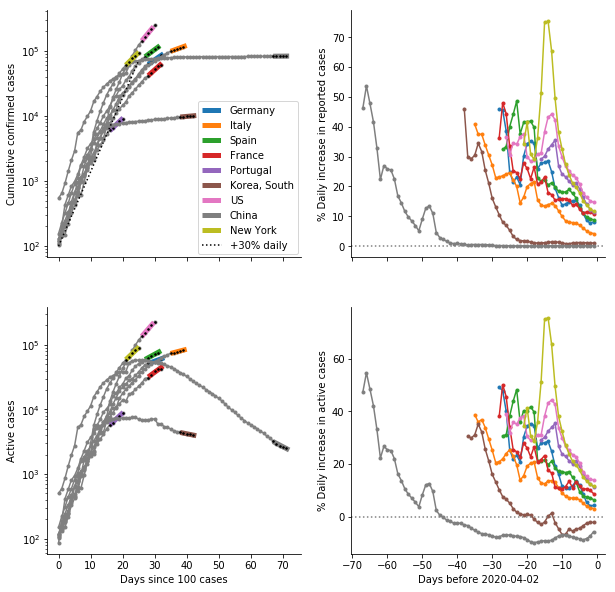

In [29]:
fix,ax=plt.subplots(2,2,figsize=(10,10),sharex='col')
ax=ax.ravel()

for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ix=df.country==c
    ts=df[ix].cases.values
    tsA=df[ix].activeCases.values
    
    caseLen=ts.shape[0]
    inflect=np.argmax(ts>100)

    x=np.arange(fitHistory)
    y=np.log10(ts[-fitHistory:])
    yA=np.log10(tsA[-fitHistory:])
    
    t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
    tx=np.linspace(0,fitHistory,100)
    j = range(ts.shape[0]-fitHistory-inflect)[-1]
    lastSlope=j+inflect+1
    s=allSlopes[ic,lastSlope]
    itc=allIntercept[ic,lastSlope]
    l=(10**itc)*(10**(s*tx))
    
    sA=allSlopesActive[ic,lastSlope]
    itcA=allInterceptActive[ic,lastSlope]
    lA=(10**itcA)*(10**(sA*tx))
    
    ax[0].plot(ts[inflect:],'.-',color='gray')
    ax[0].plot(t,l,'--',label=c,lw=5)
    ax[0].plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
    ax[2].plot(tsA[inflect:],'.-',color='gray')
    ax[2].plot(t,lA,'--',label=c,lw=5)
    ax[2].plot(x+caseLen-fitHistory-inflect,10**yA,'k.',markersize=3)


t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax[0].plot(t,e,':k',label='+30% daily')
ax[0].set_yscale('log')
ax[0].set_ylabel('Cumulative confirmed cases');
ax[2].set_xlabel('Days since 100 cases')
ax[2].set_ylabel('Active cases');
ax[2].set_yscale('log')

today=np.where(np.nansum(allSlopes,axis=0)==0)[0][1]
xt=np.arange(allSlopes.shape[1])-today
for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ax[1].plot(xt,100*(10**allSlopes[ic,:]-1),'.-',label=c);
    ax[3].plot(xt,100*(10**allSlopesActive[ic,:]-1),'.-',label=c);
    

ax[1].axhline(0,ls=':',color='gray')
ax[1].set_ylabel('% Daily increase in reported cases')

ax[3].axhline(0,ls=':',color='gray')
ax[3].set_ylabel('% Daily increase in active cases')
ax[3].set_xlabel('Days before '+ str(df.date.max()));


ax[0].legend(loc='lower right', borderaxespad=0.3)

sns.despine()

figPath='rateOfChange.png'
plt.savefig(figPath,bbox_inches='tight')


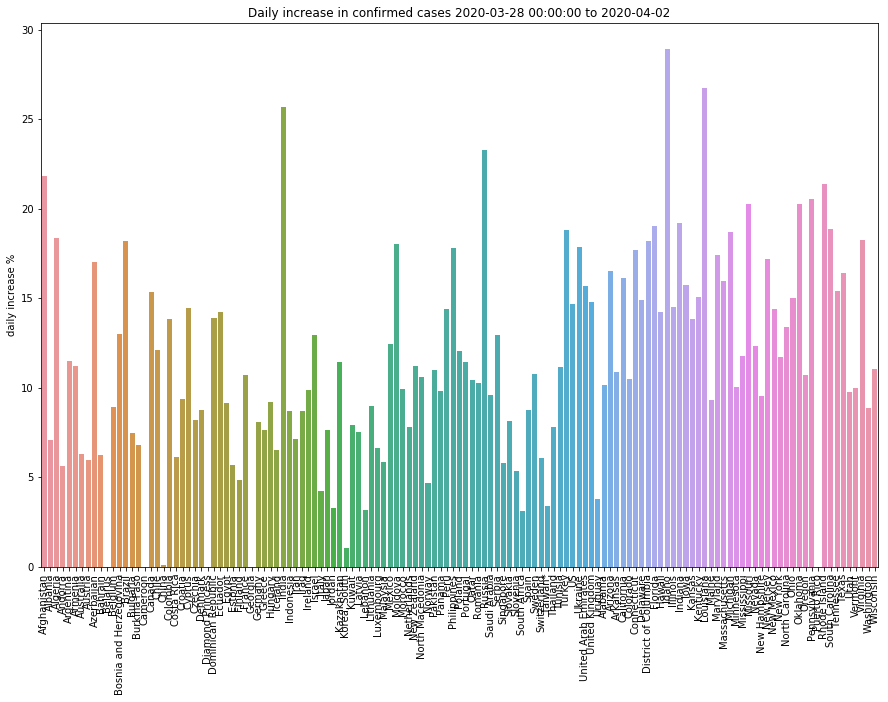

In [30]:
plt.subplots(figsize=(15,10))
sns.barplot(x=HighCountries,y=100*(10**allSlopes[:,today-1]-1))
#plt.ylim([0,.001])
plt.title('Daily increase in confirmed cases '+str(df.date.max()-pd.DateOffset(fitHistory))+' to '+str(df.date.max()))
plt.ylabel('daily increase %')
plt.xticks(rotation=90);

# Recovery

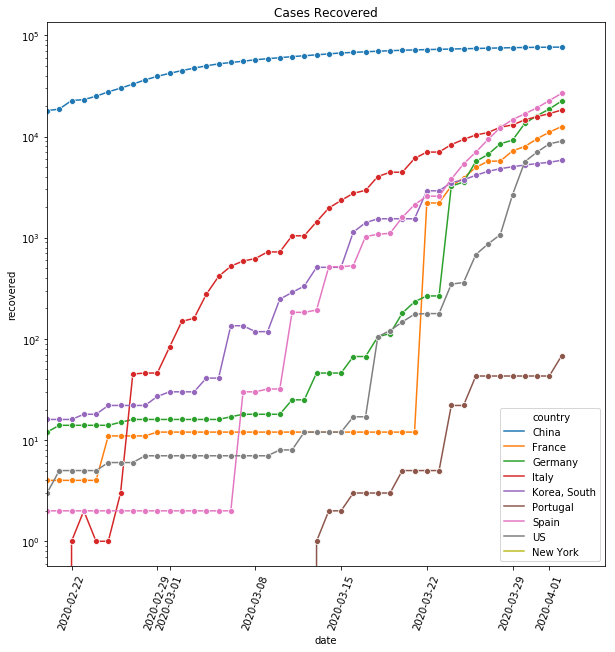

In [31]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='recovered',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Cases Recovered')
plt.xlim(left=plotStartDate);
plt.yscale('log')


# Ratio of recovered / total cases

### This ratio will eventually approach mortality, but note ~2-3 week delay from case report to recovery.

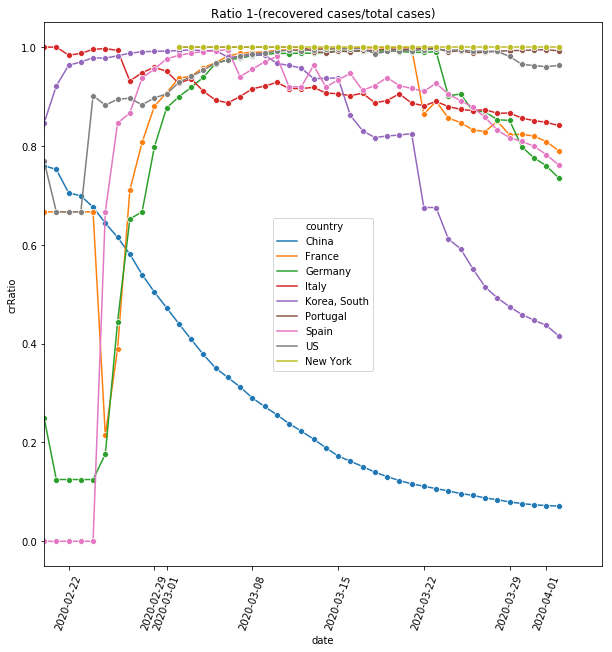

In [32]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='crRatio',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Ratio 1-(recovered cases/total cases)')
plt.xlim(left=plotStartDate);

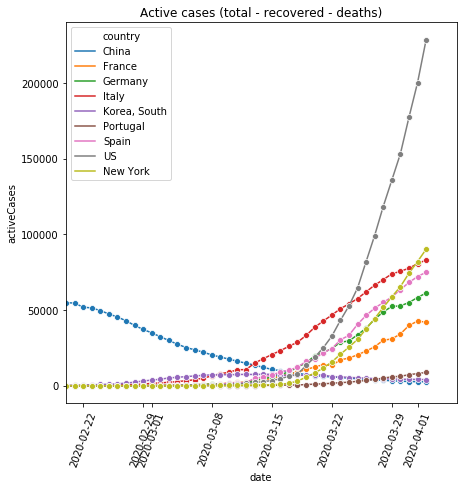

In [33]:
plt.subplots(figsize=(7,7))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='activeCases',
            hue='country',
               marker='o',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Active cases (total - recovered - deaths)')
plt.xlim(left=plotStartDate);

# Compare Robert Koch Institute (RKI) data to John's Hopkins

In [34]:
dfGermany=df[df.country=='Germany']
dfGermany.date=pd.to_datetime(dfGermany.date,utc=True)
tmp=df_rki.groupby('Meldedatum').sum().cumsum().reset_index()
tmp.Meldedatum=pd.to_datetime(tmp.Meldedatum,utc=True)#+pd.DateOffset(2)
dfGermany=dfGermany.merge(tmp[['Meldedatum','AnzahlFall']],how='right',left_on='date',right_on='Meldedatum')
dfGermany.tail()

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases,Meldedatum,AnzahlFall
46,Germany,2020-03-29 00:00:00+00:00,62095,533,9211,82667685.0,0.008584,0.000751,52351,0.851663,4400.0,2020-03-29 00:00:00+00:00,62653
47,Germany,2020-03-30 00:00:00+00:00,66885,645,13500,82667685.0,0.009643,0.000809,52740,0.798161,4790.0,2020-03-30 00:00:00+00:00,66692
48,Germany,2020-03-31 00:00:00+00:00,71808,775,16100,82667685.0,0.010793,0.000869,54933,0.775791,4923.0,2020-03-31 00:00:00+00:00,72333
49,Germany,2020-04-01 00:00:00+00:00,77872,920,18700,82667685.0,0.011814,0.000942,58252,0.759862,6064.0,2020-04-01 00:00:00+00:00,77464
50,Germany,2020-04-02 00:00:00+00:00,84794,1107,22440,82667685.0,0.013055,0.001026,61247,0.735359,6922.0,2020-04-02 00:00:00+00:00,79625


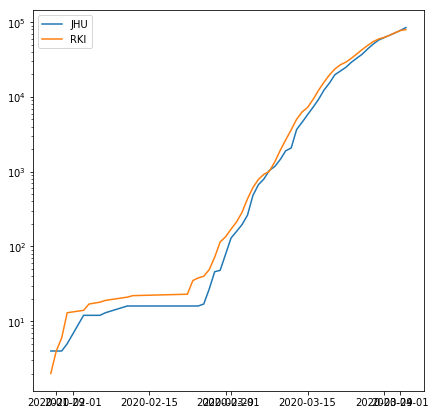

In [35]:
plt.subplots(figsize=(7,7))
plt.plot(dfGermany.date,dfGermany.cases,label='JHU')
plt.plot(dfGermany.date,dfGermany.AnzahlFall,label='RKI')
plt.yscale('log');
plt.legend();

In [36]:
df_rki.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,670153,2020-03-14 00:00:00+00:00,1001,"03.04.2020, 00:00 Uhr",0,-9
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,2,0,670154,2020-03-19 00:00:00+00:00,1001,"03.04.2020, 00:00 Uhr",0,-9
2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,670155,2020-03-21 00:00:00+00:00,1001,"03.04.2020, 00:00 Uhr",0,-9
3,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,670156,2020-03-27 00:00:00+00:00,1001,"03.04.2020, 00:00 Uhr",0,-9
4,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,670157,2020-03-14 00:00:00+00:00,1001,"03.04.2020, 00:00 Uhr",0,-9


# Cases and deaths by age group and gender

Text(0.5, 1.0, 'Faelle in Deutschland')

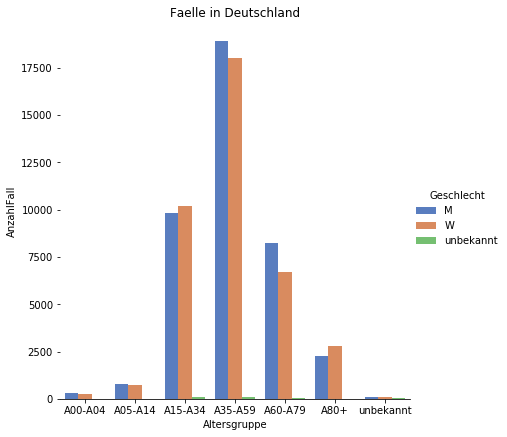

In [37]:
#fix,ax=plt.subplots(figsize=(10,10))

tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlFall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Faelle in Deutschland')

Text(0.5, 1.0, 'Todesfaelle in Deutschland')

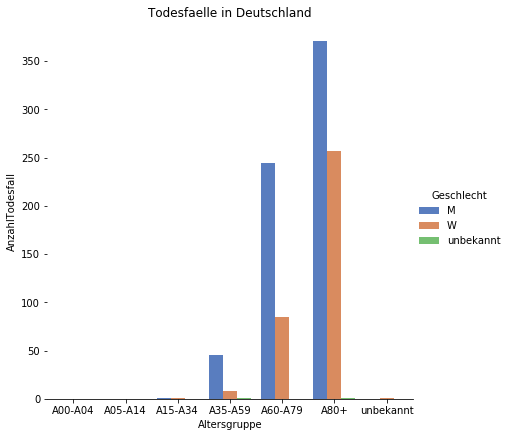

In [38]:
tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlTodesfall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Todesfaelle in Deutschland')

# Analyze states of Germany

In [39]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp.head()

,Bundesland,Meldedatum,IdBundesland,AnzahlFall,AnzahlTodesfall,ObjectId,IdLandkreis,NeuerFall,NeuerTodesfall,cases
0,Baden-Württemberg,2020-01-30 00:00:00+00:00,16,2,0,1374165,16558,0,-18,2
1,Baden-Württemberg,2020-01-31 00:00:00+00:00,24,3,0,2059998,24771,1,-27,5
2,Baden-Württemberg,2020-02-23 00:00:00+00:00,72,12,0,6171186,73788,0,-81,17
3,Baden-Württemberg,2020-02-24 00:00:00+00:00,16,2,0,1377535,16853,0,-18,19
4,Baden-Württemberg,2020-02-25 00:00:00+00:00,16,2,0,1372572,16533,0,-18,21


C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


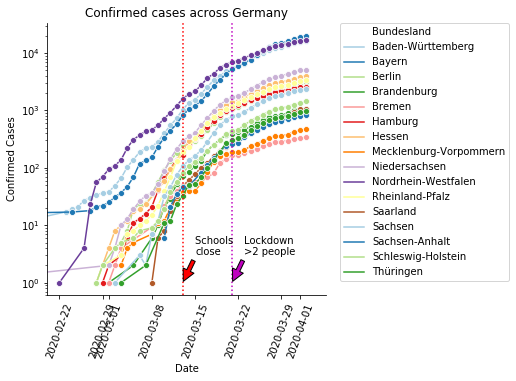

In [40]:
# Plot cases on log y scale
plt.subplots(figsize=(5,5))
plotStartDate=pd.to_datetime('2020-02-20')
sns.set_palette('Paired',16)
g=sns.lineplot(data=tmp,
             x='Meldedatum',
             y='cases',
            hue='Bundesland',
              dashes=False,
              marker='o')
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases across Germany')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(pd.to_datetime('2020-03-13'),ls=':',color='r')
plt.axvline(pd.to_datetime('2020-03-21'),ls=':',color='m')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
ax.annotate('Schools \nclose', xy=(pd.to_datetime('2020-03-13'), 1), xytext=(pd.to_datetime('2020-03-15'), 3),
            arrowprops=dict(facecolor='r', shrink=0.05),
            )

ax.annotate('Lockdown \n>2 people', xy=(pd.to_datetime('2020-03-21'), 1), xytext=(pd.to_datetime('2020-03-23'), 3),
            arrowprops=dict(facecolor='m', shrink=0.05),)

sns.despine()

In [41]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp=tmp[['Bundesland','Meldedatum','cases']]
tmp=tmp.pivot_table(columns='Bundesland',index='Meldedatum',values='cases').unstack().reset_index()
tmp.columns=[tmp.columns[0],tmp.columns[1],'cases']
tmp.head()

,Bundesland,Meldedatum,cases
0,Baden-Württemberg,2020-01-28 00:00:00+00:00,NaN
1,Baden-Württemberg,2020-01-29 00:00:00+00:00,NaN
2,Baden-Württemberg,2020-01-30 00:00:00+00:00,2.0
3,Baden-Württemberg,2020-01-31 00:00:00+00:00,5.0
4,Baden-Württemberg,2020-02-03 00:00:00+00:00,NaN


C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


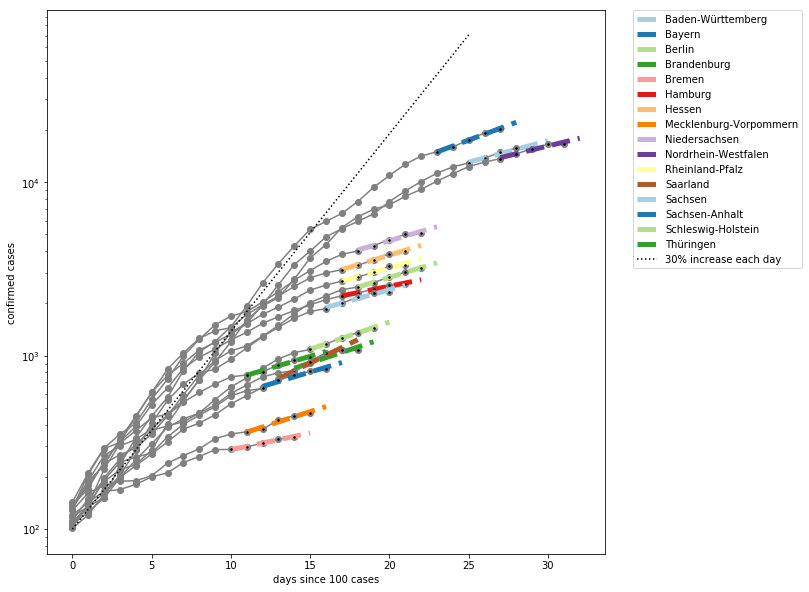

In [42]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

numStates=tmp.Bundesland.unique()

allSlopesStates=np.zeros((len(numStates),100))*np.nan

for i,c in enumerate(numStates):
    ix=tmp.Bundesland==c
    ts=tmp[ix].cases.values
    if ts[-1]>100:
        #ts=ts[ts>100]
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopesStates[i,j+inflect+1]=s
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

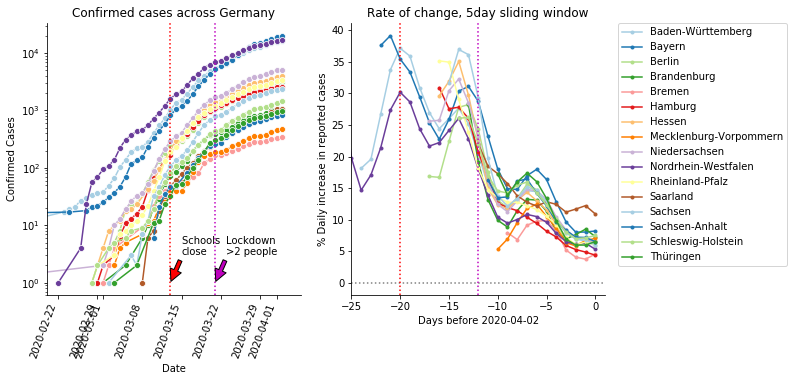

In [43]:
fix,ax=plt.subplots(1,2,figsize=(10,5))
# Plot cases on log y scale
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=tmp,
             x='Meldedatum',
             y='cases',
            hue='Bundesland',
              dashes=False,
              marker='o',ax=ax[0],legend=False)

ax[0].set_yscale('log')
plt.title('Confirmed cases, log y scale')
ax[0].set_xlim(left=plotStartDate)
plt.setp(ax[0].get_xticklabels(), ha="right", rotation=70)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



today=np.where(np.nansum(allSlopesStates,axis=0)>0)[0][-1]
todayDate=pd.to_datetime(tmp.Meldedatum.max(),utc=True).tz_convert('UTC')
xt=np.arange(allSlopesStates.shape[1])-today
for i,c in enumerate(numStates):
    ax[1].plot(xt,100*(10**allSlopesStates[i,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.axhline(0,ls=':',color='gray')
ax[1].set_ylabel('% Daily increase in reported cases')
ax[1].set_xlabel('Days before '+ str(df.date.max()));
ax[1].title.set_text('Rate of change, 5day sliding window')
ax[0].title.set_text('Confirmed cases across Germany')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].set_xlim([-25,1])

schoolLD=pd.to_datetime('2020-03-13',utc=True)
publicLD=pd.to_datetime('2020-03-21',utc=True)

ax[0].axvline(schoolLD,ls=':',color='r')
ax[0].axvline(publicLD,ls=':',color='m')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Confirmed Cases')
ax[0].annotate('Schools \nclose', xy=(schoolLD, 1), xytext=(pd.to_datetime('2020-03-15'), 3),
            arrowprops=dict(facecolor='r', shrink=0.05),
            )

ax[0].annotate('Lockdown \n>2 people', xy=(publicLD, 1), xytext=(pd.to_datetime('2020-03-23'), 3),
            arrowprops=dict(facecolor='m', shrink=0.05),)

df.date.max()

ax[1].axvline((schoolLD-todayDate).days,ls=':',color='r')
ax[1].axvline((publicLD-todayDate).days,ls=':',color='m')

sns.despine()

figPath='Germany.png'
plt.savefig(figPath,bbox_inches='tight')